In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import random
from random import randint
from matern_kernel import matern_kernel_noise_batch
import torch.nn.functional as F
from torchmetrics.image import (
    StructuralSimilarityIndexMeasure,
    PeakSignalNoiseRatio,
)
from torchmetrics.functional.image.ssim import (
    structural_similarity_index_measure,
)
from torchmetrics.functional.image.psnr import peak_signal_noise_ratio
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [3]:
def add_matern_kernel_noise_batch(sample, nu=2.5, lengthscale=1.0, sigma=1.0):
    B, C, H, W = sample.shape
    x = torch.linspace(0, 1, W, device=sample.device)
    y = torch.linspace(0, 1, H, device=sample.device)
    xx, yy = torch.meshgrid(x, y, indexing="xy")
    coords = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    noise = matern_kernel_noise_batch(
        sample=sample,
        coords=coords,
        nu=nu,
        lengthscale=lengthscale,
        sigma=sigma,
    )
    return sample + noise

In [4]:
def resize_encoder(sample):
    sample = sample.unsqueeze(0)
    sample = F.interpolate(
        sample, size=(144, 72), mode="bicubic", align_corners=False
    )
    return sample.squeeze(0)


def random_mask(sample, mask_prob=0.7):
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image


class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x_0_9 = random_mask(x, mask_prob=0.9)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        masked_x_0_5 = random_mask(x, mask_prob=0.5)
        masked_x_0_3 = random_mask(x, mask_prob=0.3)
        y = idx
        return (
            x_orig,
            x,
            masked_x_0_9,
            masked_x,
            masked_x_0_5,
            masked_x_0_3,
            y,
        )

In [5]:
def compute_errors(testloader, model, add_noise=False):
    mse_loss = torch.nn.MSELoss()
    l1_loss = torch.nn.L1Loss()
    mse_0_9 = []
    mse_0_7 = []
    mse_0_5 = []
    mse_0_3 = []
    l1_0_9 = []
    l1_0_7 = []
    l1_0_5 = []
    l1_0_3 = []
    for batch in testloader:
        with torch.no_grad():
            masked_0_9 = batch[2].to(DEVICE)
            masked_0_7 = batch[3].to(DEVICE)
            masked_0_5 = batch[4].to(DEVICE)
            masked_0_3 = batch[5].to(DEVICE)
            data = batch[0].to(DEVICE)
            if add_noise:
                masked_0_9 = add_matern_kernel_noise_batch(masked_0_9)
                masked_0_7 = add_matern_kernel_noise_batch(masked_0_7)
                masked_0_5 = add_matern_kernel_noise_batch(masked_0_5)
                masked_0_3 = add_matern_kernel_noise_batch(masked_0_3)

            _, recon_0_9 = model(masked_0_9)
            _, recon_0_7 = model(masked_0_7)
            _, recon_0_5 = model(masked_0_5)
            _, recon_0_3 = model(masked_0_3)

            mse_0_9_loss = mse_loss(recon_0_9, data)
            mse_0_9.append(mse_0_9_loss.item())
            mse_0_7_loss = mse_loss(recon_0_7, data)
            mse_0_7.append(mse_0_7_loss.item())
            mse_0_5_loss = mse_loss(recon_0_5, data)
            mse_0_5.append(mse_0_5_loss.item())
            mse_0_3_loss = mse_loss(recon_0_3, data)
            mse_0_3.append(mse_0_3_loss.item())

            l1_0_9_loss = l1_loss(recon_0_9, data)
            l1_0_9.append(l1_0_9_loss.item())
            l1_0_7_loss = l1_loss(recon_0_7, data)
            l1_0_7.append(l1_0_7_loss.item())
            l1_0_5_loss = l1_loss(recon_0_5, data)
            l1_0_5.append(l1_0_5_loss.item())
            l1_0_3_loss = l1_loss(recon_0_3, data)
            l1_0_3.append(l1_0_3_loss.item())

    print(f"Masked 90% MSE Loss: {np.mean(mse_0_9):.4f}")
    print(f"Masked 70% MSE Loss: {np.mean(mse_0_7):.4f}")
    print(f"Masked 50% MSE Loss: {np.mean(mse_0_5):.4f}")
    print(f"Masked 30% MSE Loss: {np.mean(mse_0_3):.4f}")

    print(f"Masked 90% L1 Loss: {np.mean(l1_0_9):.4f}")
    print(f"Masked 70% L1 Loss: {np.mean(l1_0_7):.4f}")
    print(f"Masked 50% L1 Loss: {np.mean(l1_0_5):.4f}")
    print(f"Masked 30% L1 Loss: {np.mean(l1_0_3):.4f}")

    means = [
        np.mean(mse_0_9),
        np.mean(mse_0_7),
        np.mean(mse_0_5),
        np.mean(mse_0_3),
    ]

    labels = ["90%", "70%", "50%", "30%"]

    plt.bar(labels, means)
    plt.xlabel("Masking Ratio")
    plt.ylabel("Mean MSE")
    plt.title("Mean Reconstruction MSE Los sat Different Masking Ratios")
    plt.show()

    means = [
        np.mean(l1_0_9),
        np.mean(l1_0_7),
        np.mean(l1_0_5),
        np.mean(l1_0_3),
    ]

    labels = ["90%", "70%", "50%", "30%"]

    plt.bar(labels, means)
    plt.xlabel("Masking Ratio")
    plt.ylabel("Mean MSE")
    plt.title("Mean Reconstruction L1 Loss at Different Masking Ratios")
    plt.show()

In [6]:
model = torch.load(
    "simclr_decoder_freeze.pth", weights_only=False, map_location=DEVICE
)
model.eval()
data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
data = data[n_train + n_valid :]
BATCH_SIZE = 128
n_samples = data.shape[0]

n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)

train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std

Masked 90% MSE Loss: 0.1499
Masked 70% MSE Loss: 0.1434
Masked 50% MSE Loss: 0.1435
Masked 30% MSE Loss: 0.1444
Masked 90% L1 Loss: 0.2581
Masked 70% L1 Loss: 0.2529
Masked 50% L1 Loss: 0.2527
Masked 30% L1 Loss: 0.2532


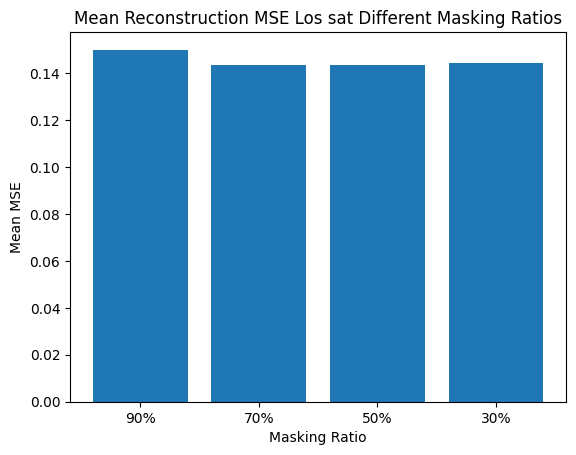

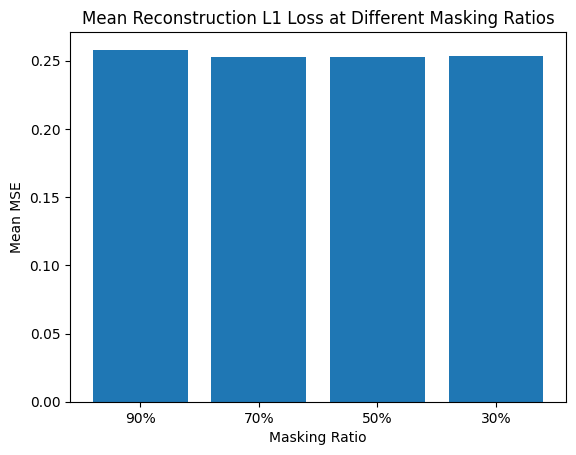

In [7]:
# 70% Mask Ratio Plots
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
compute_errors(testloader, model)

Masked 90% MSE Loss: 0.2727
Masked 70% MSE Loss: 0.2037
Masked 50% MSE Loss: 0.1849
Masked 30% MSE Loss: 0.1798
Masked 90% L1 Loss: 0.3488
Masked 70% L1 Loss: 0.3022
Masked 50% L1 Loss: 0.2882
Masked 30% L1 Loss: 0.2844


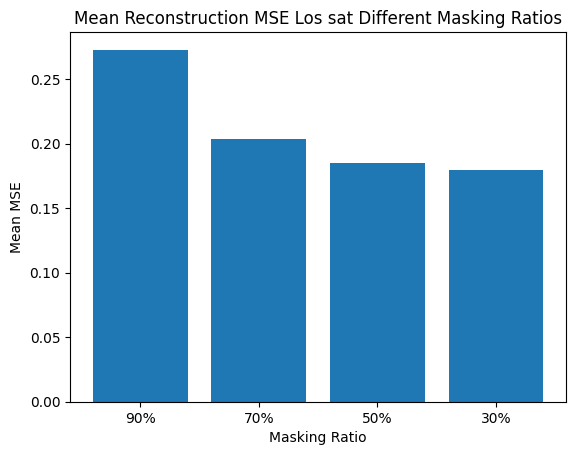

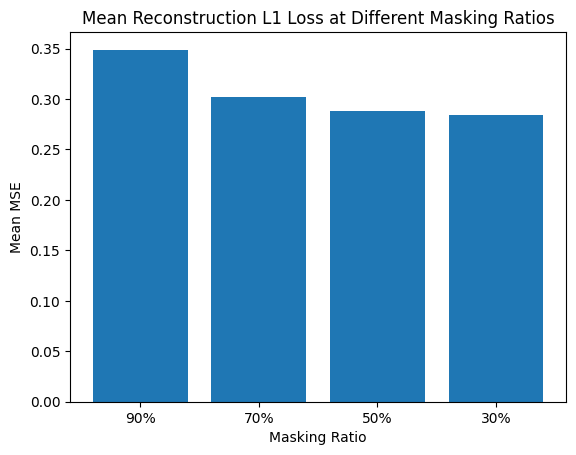

In [8]:
compute_errors(testloader, model, add_noise=True)

In [9]:
batch = next(iter(testloader))
masked_0_9 = batch[2].to(DEVICE)
masked_0_7 = batch[3].to(DEVICE)
masked_0_5 = batch[4].to(DEVICE)
masked_0_3 = batch[5].to(DEVICE)
data = batch[0].to(DEVICE)

In [10]:
with torch.no_grad():
    _, recon_0_9 = model(masked_0_9)
    _, recon_0_7 = model(masked_0_7)
    _, recon_0_5 = model(masked_0_5)
    _, recon_0_3 = model(masked_0_3)

In [11]:
recon_0_9_t = (
    recon_0_9[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
recon_0_7_t = (
    recon_0_7[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
recon_0_5_t = (
    recon_0_5[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
recon_0_3_t = (
    recon_0_3[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)

masked_0_9_t = (
    masked_0_9[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
masked_0_7_t = (
    masked_0_7[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
masked_0_5_t = (
    masked_0_5[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
masked_0_3_t = (
    masked_0_3[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)

original_t = (
    data[:, 0, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)


recon_images = [recon_0_9_t, recon_0_7_t, recon_0_5_t, recon_0_3_t]
masked_images = [masked_0_9_t, masked_0_7_t, masked_0_5_t, masked_0_3_t]

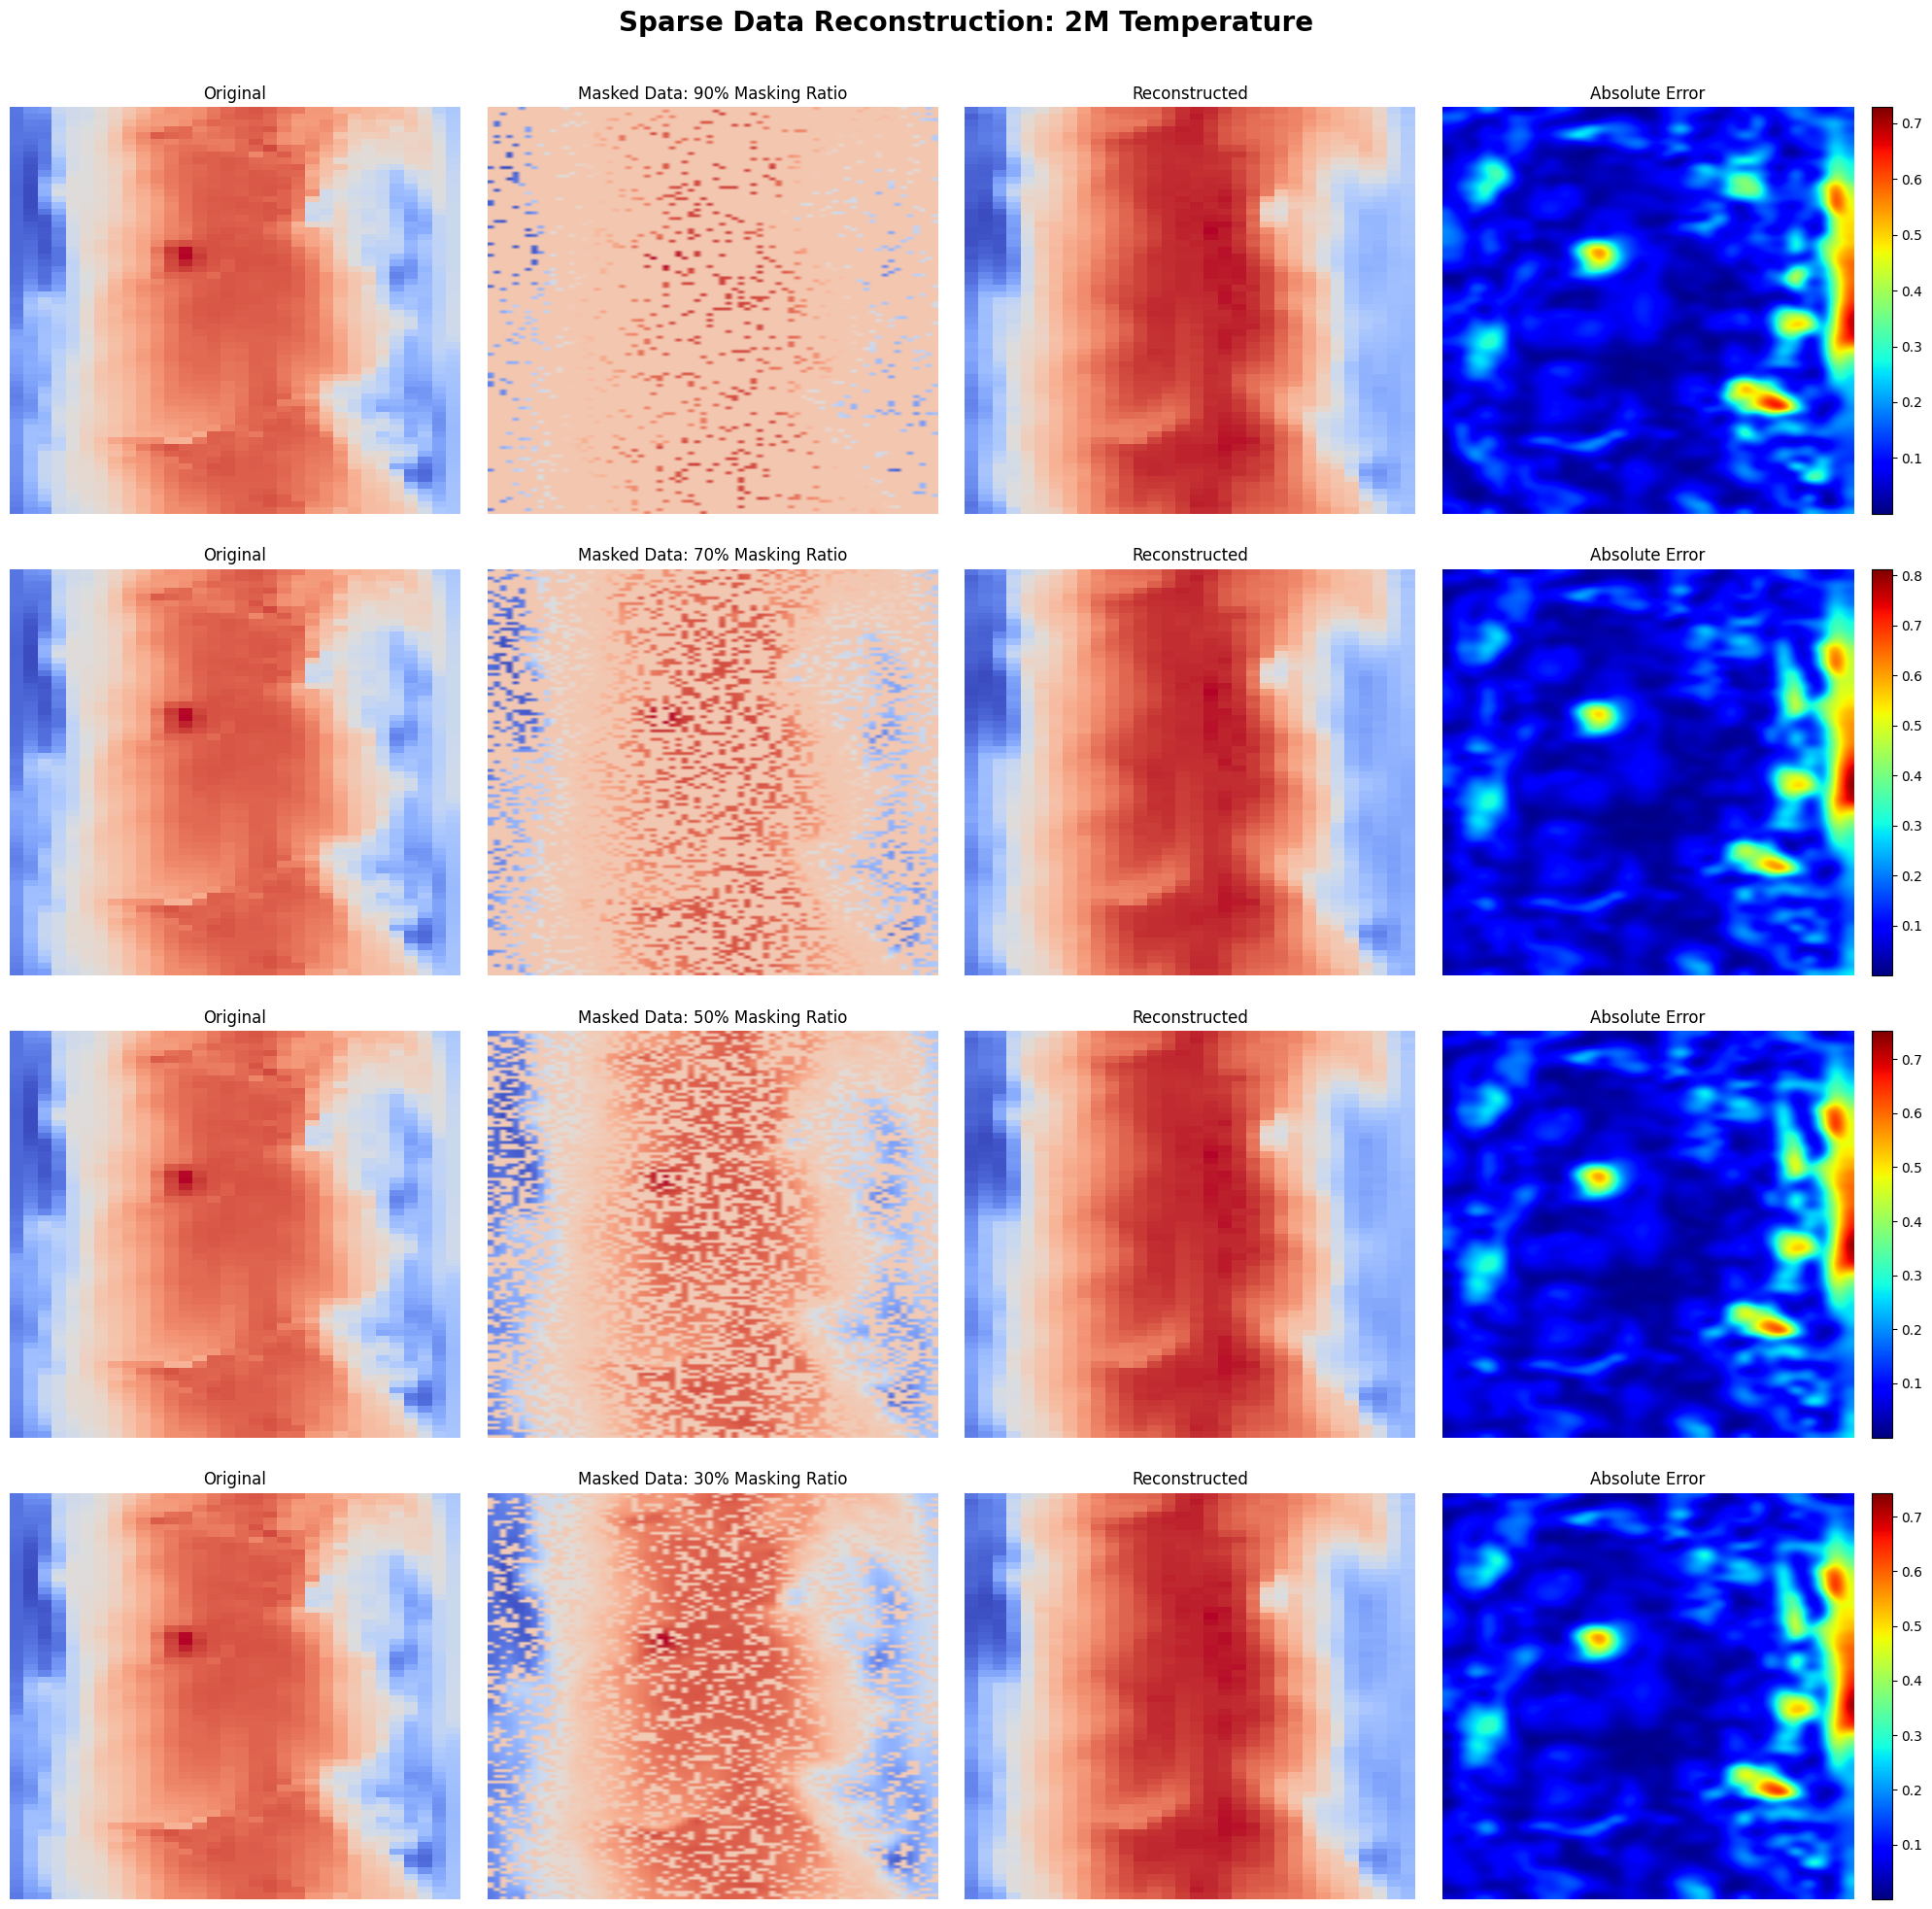

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
masks = ["90%", "70%", "50%", "30%"]
for i, (recon, masked) in enumerate(zip(recon_images, masked_images)):
    error = np.abs(recon - original_t)
    mask = masks[i]

    axs[i, 0].imshow(original_t, cmap="coolwarm", aspect="auto")
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(masked, cmap="coolwarm", aspect="auto")
    axs[i, 1].set_title(f"Masked Data: {mask} Masking Ratio")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(recon, cmap="coolwarm", aspect="auto")
    axs[i, 2].set_title("Reconstructed")
    axs[i, 2].axis("off")

    im = axs[i, 3].imshow(
        error, cmap="jet", aspect="auto", interpolation="bicubic"
    )
    axs[i, 3].set_title("Absolute Error")
    axs[i, 3].axis("off")

    fig.colorbar(im, ax=axs[i, 3], fraction=0.046, pad=0.04)
fig.suptitle(
    "Sparse Data Reconstruction: 2M Temperature",
    fontsize=20,
    fontweight="bold",
)
plt.tight_layout(rect=[0, 0, 1, 0.97], w_pad=2.0, h_pad=2.5)
plt.show()

In [13]:
recon_0_9_u = (
    recon_0_9[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
recon_0_7_u = (
    recon_0_7[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
recon_0_5_u = (
    recon_0_5[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
recon_0_3_u = (
    recon_0_3[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)

masked_0_9_u = (
    masked_0_9[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
masked_0_7_u = (
    masked_0_7[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
masked_0_5_u = (
    masked_0_5[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)
masked_0_3_u = (
    masked_0_3[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)

original_u = (
    data[:, 1, :, :].unsqueeze(1).permute(0, 2, 3, 1).cpu().numpy()[0]
)


recon_images = [recon_0_9_u, recon_0_7_u, recon_0_5_u, recon_0_3_u]
masked_images = [masked_0_9_u, masked_0_7_u, masked_0_5_u, masked_0_3_u]

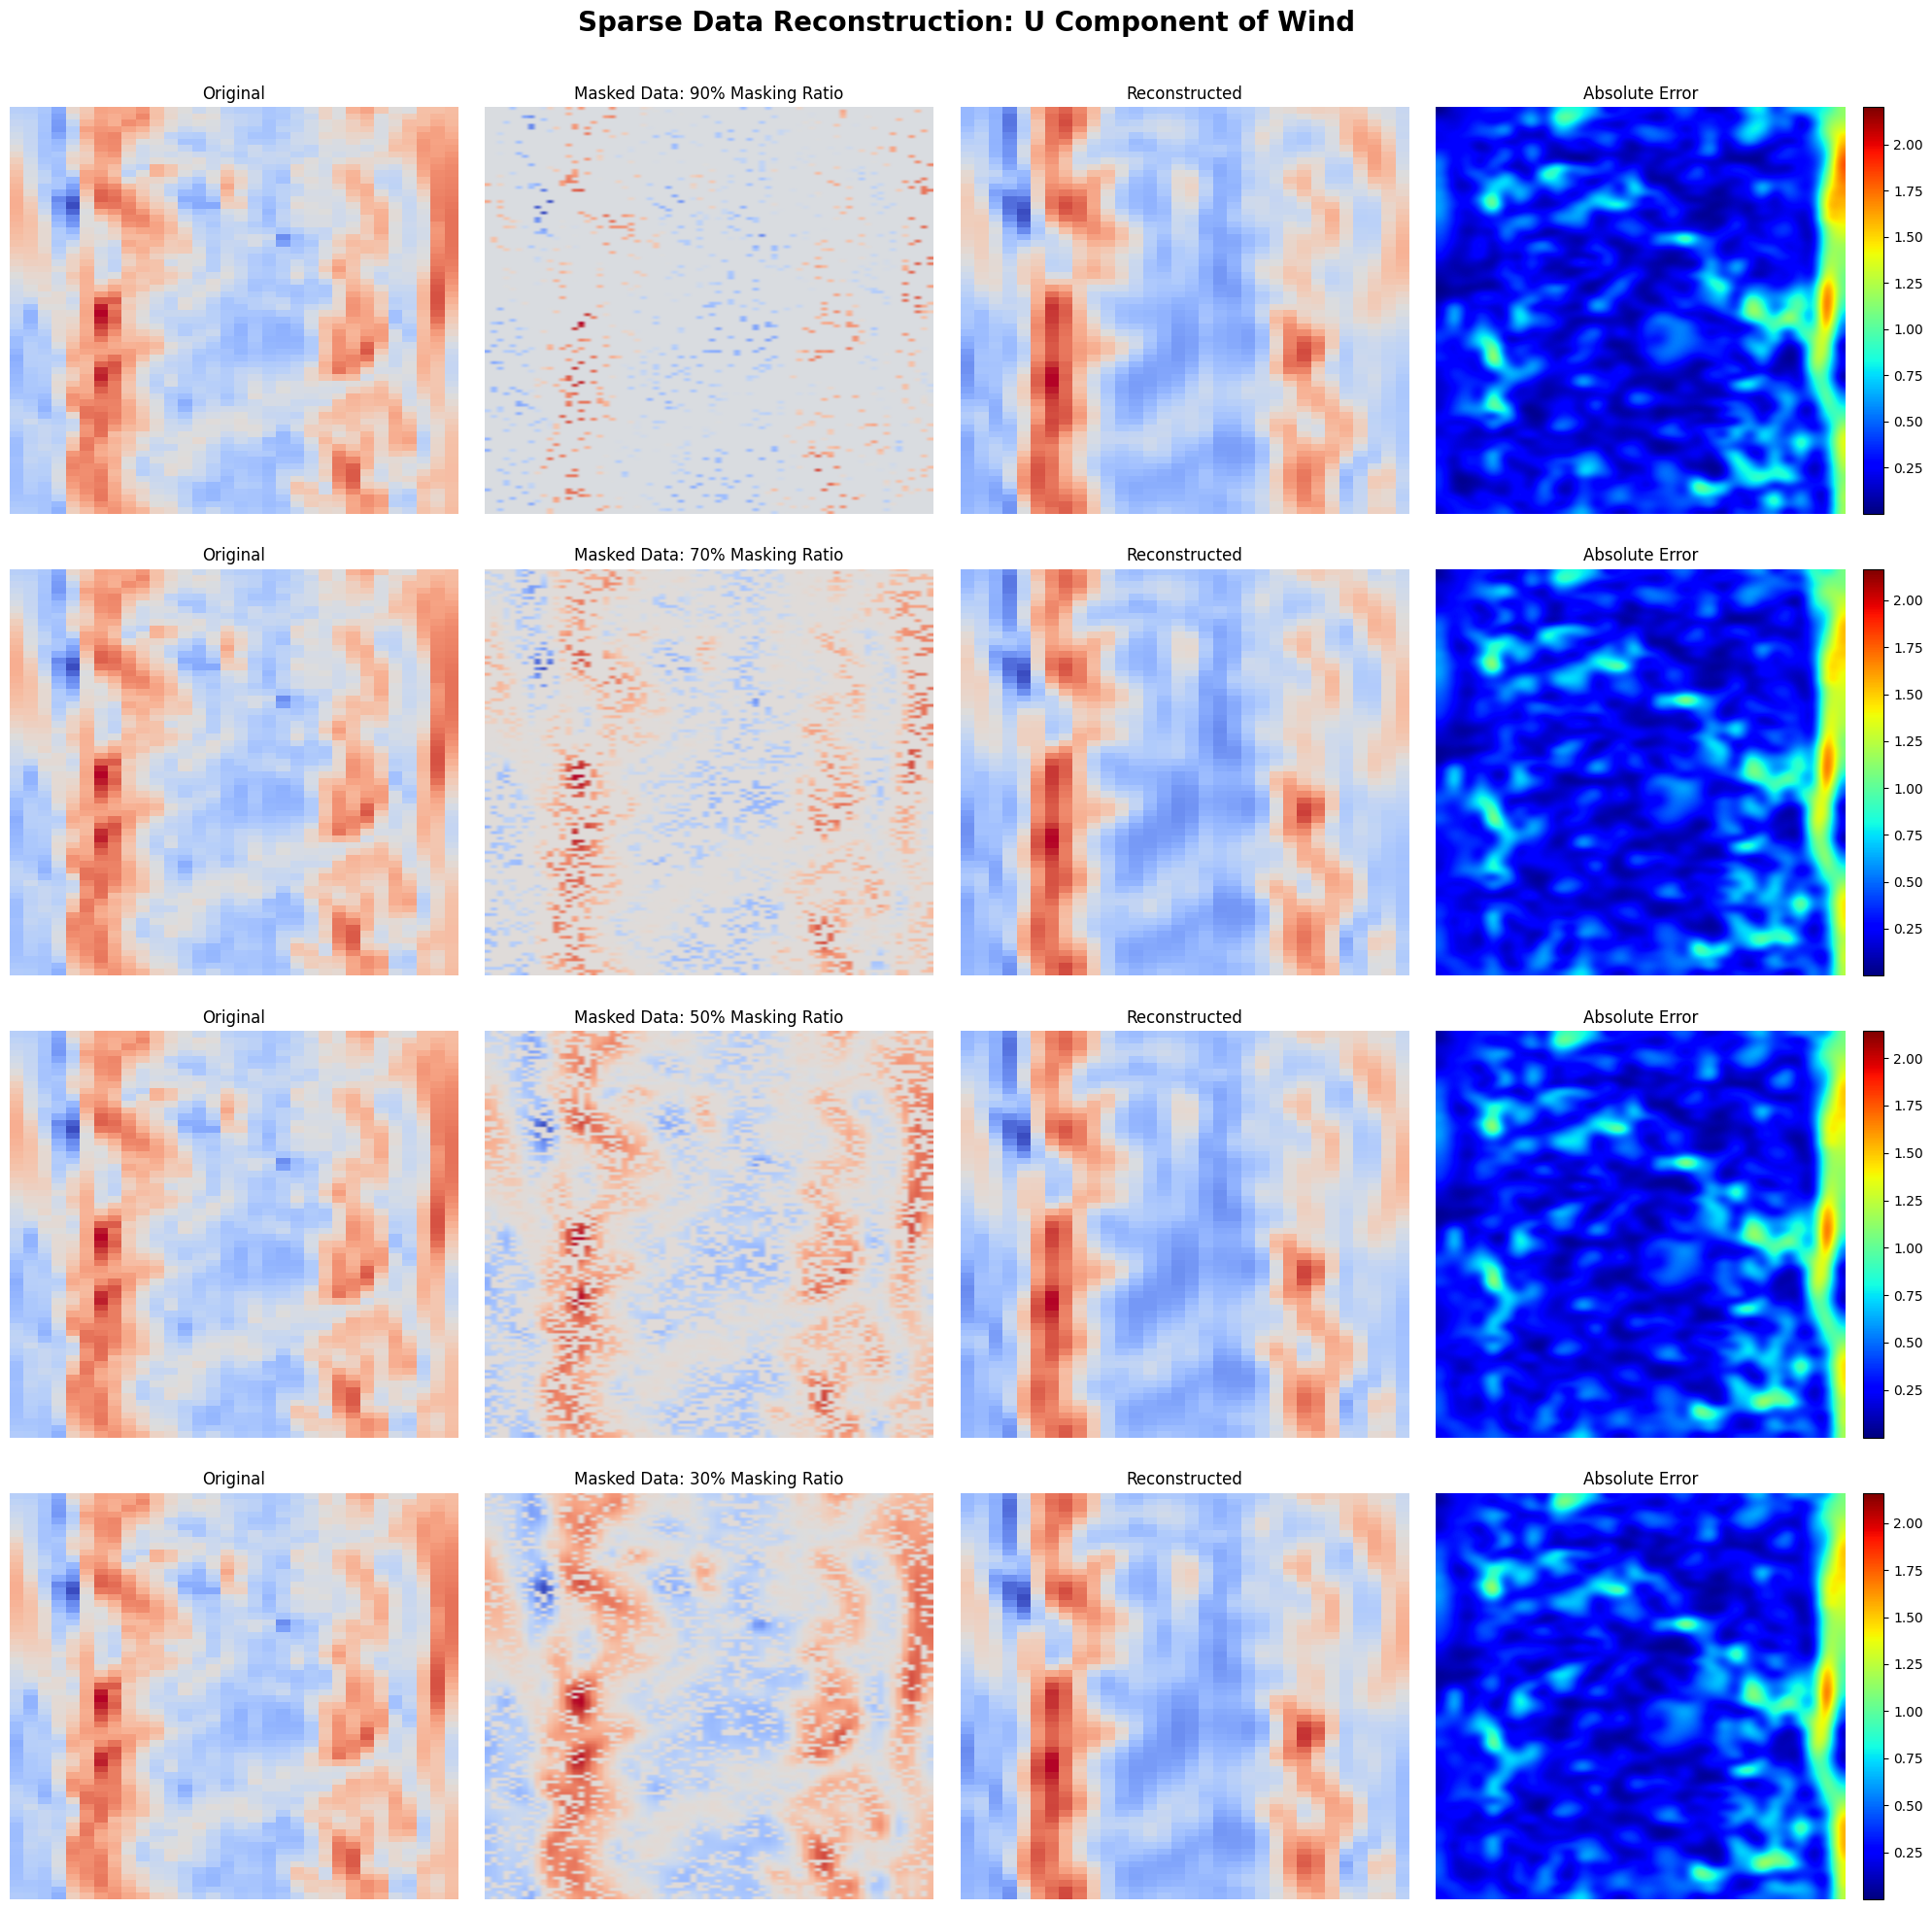

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
masks = ["90%", "70%", "50%", "30%"]
for i, (recon, masked) in enumerate(zip(recon_images, masked_images)):
    error = np.abs(recon - original_u)
    mask = masks[i]

    axs[i, 0].imshow(original_u, cmap="coolwarm", aspect="auto")
    axs[i, 0].set_title("Original")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(masked, cmap="coolwarm", aspect="auto")
    axs[i, 1].set_title(f"Masked Data: {mask} Masking Ratio")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(recon, cmap="coolwarm", aspect="auto")
    axs[i, 2].set_title("Reconstructed")
    axs[i, 2].axis("off")

    im = axs[i, 3].imshow(
        error, cmap="jet", aspect="auto", interpolation="bicubic"
    )
    axs[i, 3].set_title("Absolute Error")
    axs[i, 3].axis("off")

    fig.colorbar(im, ax=axs[i, 3], fraction=0.046, pad=0.04)
fig.suptitle(
    "Sparse Data Reconstruction: U Component of Wind",
    fontsize=20,
    fontweight="bold",
)
plt.tight_layout(rect=[0, 0, 1, 0.97], w_pad=2.0, h_pad=2.5)
plt.show()